In [ ]:
! pip install --quiet "ipython[notebook]==7.34.0, <8.17.0" "setuptools>=68.0.0, <68.3.0" "xgboost" "tensorboard" "lightning>=2.0.0" "urllib3" "torch==2.3.0" "matplotlib" "pytorch-lightning>=1.4, <2.1.0" "seaborn" "torchvision" "torchmetrics>=0.7, <1.3" "matplotlib>=3.0.0, <3.9.0"

In [1]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import seaborn as sns
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from torchvision import transforms
import pandas as pd
import numpy as np
from torchvision.io import read_image
from sklearn.metrics import r2_score

TRAIN_IMAGES_DATA_PATH = "./train_images"
TEST_IMAGES_DATA_PATH = "./test_images"
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/")

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.reset_orig()

L.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Seed set to 42


Using mps device


<Figure size 640x480 with 0 Axes>

Seed set to 42
Seed set to 42
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([17081,   991,    29, 14835, 19497, 12069, 39790, 16701, 38332, 38207,
          376, 28007, 33754,  5023, 35536, 28795, 41213, 16536,  4966, 31340,
        24672, 36096,  9197, 25693, 20735, 36255, 31665, 13757, 28306, 24458,
        42251, 17181, 10581, 39694, 17482, 39111, 38928,  9297, 25788, 19592,
        16234, 22253, 29806, 32611, 23674, 32368, 33148, 31577, 17783,  9975,
        38177, 16166, 32644, 38903,  1978, 25499, 41963, 10441, 15015, 16557,
         1910, 34134, 25985, 33880])

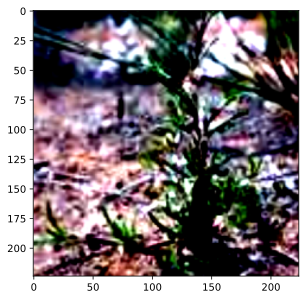

In [2]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from data_set import PlantDataset

from sklearn.preprocessing import MinMaxScaler

def ClipFeatures(df: pd.DataFrame):
    std = df.std()
    means = df.mean()
    for column in df.columns:
        df[column] = df[column].values.clip(means[column] - 5 * std[column], means[column] + 5 * std[column])
    return df

def ScaleMinMax(df: pd.DataFrame):
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df)
    return df

csv_transforms = transforms.Compose([
    ClipFeatures,
    ScaleMinMax
])

img_transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_transform_test = test_transform = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

full_training_data = PlantDataset('train.csv', 'train_images', num_labels=6, csv_transform=csv_transforms, image_transform=img_transform_train)
full_val_data = PlantDataset('train.csv', 'train_images', num_labels=6, csv_transform=csv_transforms, image_transform=img_transform_test)
train_size = len(full_training_data)

val_size = int(0.15 * len(full_training_data))
train_size = train_size - val_size

L.seed_everything(42)
train_data, _ = random_split(full_training_data, [train_size, val_size])
L.seed_everything(42)
_, val_data = random_split(full_val_data, [train_size, val_size])

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

test_data = PlantDataset('test.csv', 'test_images', num_labels=0, csv_transform=csv_transforms, image_transform=img_transform_test)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

idx, row, img, y = next(iter(train_dataloader))
plt.imshow(img[0].permute(1,2,0))
len(train_data)
idx

In [ ]:
data = full_training_data.labels.iloc[:, 3].to_frame()
data = np.log(data)
data = (data - np.mean(data)) / (max(data.values) - min(data.values))
sns.displot(data, x = full_training_data.labels.columns[3])
(np.array(data) > 0.4).sum()

In [ ]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 1)
        )

    def forward(self, img):
        conv_out = self.conv_layers(img)
        conv_out = conv_out.view(conv_out.size(0), -1)

        # concat = torch.concat((conv_out, csv_out), 1)
        out = self.fully_connected_layers(conv_out)
        return out

model = ConvModel().to(device=device)
print(sum(p.numel() for p in model.parameters()))
with torch.no_grad():
    model(img.to(device)).shape

In [ ]:
class CombinedModel(L.LightningModule):
    def __init__(self, label_idx, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.conv = ConvModel(**model_kwargs)
        self.example_input_array = tuple(next(iter(train_dataloader))[1:3])  # For plotting the computation graph
        self.label_idx = label_idx

    def forward(self, idx, row, img):
        return self.conv(img)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=0.0005)
        return [optimizer], []

    def _calculate_loss(self, batch, mode="train"):
        idxs, rows, imgs, labels = batch

        preds = self.conv(imgs)
        loss = F.mse_loss(torch.squeeze(preds), labels[:, self.label_idx])
        self.log(f"{mode}_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        pass


In [ ]:
import glob
import os

def train_model(label_idx, model = None, version=0, **kwargs):
    list_of_files = glob.glob(os.path.join(CHECKPOINT_PATH, f"Model_label_{label_idx}/lightning_logs/version_{version}/checkpoints/*.ckpt")) # * means all if need specific format then *.csv
    pretrained_path = max(list_of_files, key=os.path.getctime) if list_of_files else None
    L.seed_everything(42)
    if model is None and pretrained_path is not None and os.path.isfile(pretrained_path):
        print(f"Found pretrained model at {pretrained_path}, loading...")
        model = CombinedModel.load_from_checkpoint(pretrained_path)
        return model

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, f"Model_label_{label_idx}"),
        accelerator="auto",
        devices=1,
        max_epochs=5,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="epoch"),
            EarlyStopping(monitor='val_loss', patience=2),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    # Check for an existing pretrained model
    list_of_files = glob.glob(os.path.join(CHECKPOINT_PATH, f"Model_label_{label_idx}/lightning_logs/version_{version}/checkpoints/*.ckpt")) # * means all if need specific format then *.csv
    pretrained_path = max(list_of_files, key=os.path.getctime) if list_of_files else None
    L.seed_everything(42)
    if model is None and pretrained_path is not None and os.path.isfile(pretrained_path):
        print(f"Found pretrained model at {pretrained_path}, loading...")
        model = CombinedModel.load_from_checkpoint(pretrained_path)
    else:
        if model is None:
            model = CombinedModel(label_idx=label_idx, **kwargs)
        trainer.fit(model, train_dataloader, val_dataloader)
        # Load the best checkpoint after training
        model = CombinedModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Evaluate the best model on validation and test sets
    trainer.test(model, dataloaders=val_dataloader, verbose=False)
    # test_result = trainer.test(model, dataloaders=test_dataloader, verbose=False)
    # results = {"val": val_result[0]["val_loss"]}

    return model

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%reload_ext tensorboard
%tensorboard --logdir ./saved_models


In [48]:
import xgboost

class XGBBoost:
    def __init__(self, num_targets = 6, **kwargs):
        if "n_estimators" not in kwargs:
            kwargs["n_estimators"] = 90
        if "max_depth" not in kwargs:
            kwargs["max_depth"] = 3
        self.num_targets = num_targets
        self.xgb = [xgboost.XGBRegressor(**kwargs) for _ in range(num_targets)]
        
    def fit(self, X_train, Y_train, X_val, Y_val):
        for i in range(self.num_targets):
            self.xgb[i].fit(X_train, Y_train[:, i])
            
            pred = self.xgb[i].predict(X_val)
            print (F.mse_loss(torch.tensor(pred), torch.tensor(Y_val[:, i])))
        
        print (f"Test R2 Score: {r2_score(Y_train, XGBBoost.predict(self, X_train))}")
        print (f"Val R2 Score: {r2_score(Y_val, XGBBoost.predict(self, X_val))}")
    
    def predict(self, X):
        res = np.zeros((self.num_targets, len(X)))
        for i in range(self.num_targets):
            res[i] = self.xgb[i].predict(X)
        return res.transpose()

In [13]:
full_training_data.labels.iloc[train_data.indices].values.shape

(36859, 6)

In [49]:
xgb = XGBBoost()

xgb.fit(
    X_train=full_training_data.csv_data.iloc[train_data.indices].values,
    Y_train=full_training_data.labels.iloc[train_data.indices].values,
    X_val=full_val_data.csv_data.iloc[val_data.indices].values,
    Y_val=full_val_data.labels.iloc[val_data.indices].values
)

tensor(0.0158, dtype=torch.float64)
tensor(38.2896, dtype=torch.float64)
tensor(14.1881, dtype=torch.float64)
tensor(3392.4404, dtype=torch.float64)
tensor(0.3118, dtype=torch.float64)
tensor(3972782.8155, dtype=torch.float64)
Test R2 Score: 0.2774908416230824
Val R2 Score: 0.1875547277177434


In [50]:
class XGBBoostAugmented(XGBBoost):
    def __init__(self, model, num_targets=6, **kwargs):
        super().__init__(num_targets, **kwargs)
        self.extra_info = None
        self.model = model
        self.augmented = {}
    
    def fit(self, train_loader, val_loader):
        train_aug = self._augment(train_loader, len(train_loader.dataset.dataset), "train")[train_loader.dataset.indices]

        X_train = train_loader.dataset.dataset.csv_data.values[train_loader.dataset.indices]
        X_train_aug = np.concatenate((X_train, train_aug), axis=1)
        Y_train = train_loader.dataset.dataset.labels.values[train_loader.dataset.indices]
        
        val_aug = self._augment(val_loader, len(val_loader.dataset.dataset), "val")[val_loader.dataset.indices]
        X_val = val_loader.dataset.dataset.csv_data.values[val_loader.dataset.indices]
        X_val_aug = np.concatenate((X_val, val_aug), axis=1)
        Y_val = val_loader.dataset.dataset.labels.values[val_dataloader.dataset.indices]
        
        super().fit(X_train=X_train_aug, Y_train=Y_train, X_val=X_val_aug, Y_val=Y_val)
    
    def predict(self, test_loader):
        test_aug = self._augment(test_loader, len(test_loader.dataset), "test")
        X_test = test_loader.dataset.csv_data.values
        X_aug = np.concatenate((X_test, test_aug), axis=1)
        return super().predict(X_aug)
    
    def _augment(self, loader : DataLoader, dataset_size, key):
        if key in self.augmented:
            return self.augmented[key]

        extra_info = np.zeros((dataset_size, 768))
        with torch.no_grad():
            for i, (idx, _, imgs, _) in enumerate(loader):
                extra_info[idx] = self.model(imgs.to(device)).cpu().detach().numpy()
                if i % 10 == 0:
                    print (f"Done augmenting {i}th batch")
        self.augmented[key] = extra_info
        return self.augmented[key]


In [63]:
xgb_aug = XGBBoostAugmented(
    model=torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg').to(device),
    num_targets=6,
    n_estimators = 110,
    max_depth = 4,
    eta = 0.15,
    subsample = 0.9
)
try:
    xgb_aug.augmented = cached_augmented
except NameError:
    pass

Using cache found in /Users/sriharivishnu/.cache/torch/hub/facebookresearch_dinov2_main


In [64]:
xgb_aug.fit(train_loader=train_dataloader, val_loader=val_dataloader)

tensor(0.0121, dtype=torch.float64)
tensor(30.3970, dtype=torch.float64)
tensor(8.9190, dtype=torch.float64)
tensor(3016.0773, dtype=torch.float64)
tensor(0.2567, dtype=torch.float64)
tensor(3277358.4039, dtype=torch.float64)
Test R2 Score: 0.5131700517682457
Val R2 Score: 0.3572577821960614


In [8]:
idx, row, img, y = next(iter(test_dataloader))

In [65]:
preds = xgb_aug.predict(test_dataloader)

In [66]:
preds.shape


(6391, 6)

In [69]:
import csv
with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
    for i in range(len(preds)):
      writer.writerow([test_data.ids[i], preds[i][0], preds[i][1], preds[i][2], preds[i][3], preds[i][4], preds[i][5]])



In [68]:
compare = xgb.predict(test_data.csv_data.values)
r2_score(preds, compare)

0.39523001741427866